# Detecting patterns of speciation in the fos- sil record

In this assignment, we use data from the NOW (New and Old Worlds) database of fossil mammals to study patterns of speciation over time and space. In particular, we are interested to know when and where speciation rates have been significantly high. The task is to find which time periods and which places over the history of mammals have given rise to exceptionally high numbers of new species. The phenomenon is known in the evolutionary literature as the “species factory”. Palaeontologists are interested why and in which ways those times and places are special. The role of computational science is to identify and characterize such times and places.
We practice using pandas DataFrames, performing logistic regression and making statistical significance tests in data analysis.

## imports

In [303]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas
from shapely.geometry import Point
import statsmodels.api as sm
from scipy.stats import binom
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
# print(os.getcwd())


## 1-2 Create DataFrame and save it as csv file
Create a pandas DataFrame that contains all of the data and save it as a csv file. How many rows does the DataFrame contain? 

In [304]:
def get_data():   
    data = pd.read_csv("nowdatabase.txt", sep=',', encoding='latin-1', dtype=str)
    data.to_csv('data.csv', index=False)
    data.dropna(subset=['LAT', 'LONG', 'MAX_AGE', 'MIN_AGE'], how='all', inplace=True)

    return data

def get_rows():
    data = get_data()
    num_rows = data.shape[0]
    return num_rows


if __name__ == '__main__':
    number = get_rows()
    print(f"The dataframe contains {number} rows.")

The dataframe contains 83225 rows.


### Idea of solution
get_data()function reads the data from the "nowdatabase.txt" file using pd.read_csv() function, specifying the appropriate parameters for file parsing. It then saves the data to a CSV file named "data.csv" using to_csv() method. Afterward, it drops rows with missing values in the 'LAT', 'LONG', 'MAX_AGE', and 'MIN_AGE' columns using dropna(). Finally, it returns the cleaned DataFrame.

## 3 Cleaning and processing steps
a) Remove all rows where LAT = LONG = 0; these occur- rences have incorrect coordinates. Drop rows where SPECIES is “sp.” or “indet.”; these occurrences have not been properly identified.<br/>
b) Next we will assign each occurrence to a specific Mammal Neogene (MN) time unit. Table 1 shows the time boundaries of each time unit. Assign each occurrence to a correct time unit by calculating the mean of MIN AGE and MAX AGE. If the mean age of an occurrence is precisely on the boundary between two time units, assign the occurrence to the older time unit. If the mean age of an occurrence is outside of the MN time interval, assign it to a “pre-MN” or “post-MN” category.<br/>
c) Sometimes expert knowledge may be used to override some of the information recorded in the data. In our case, experts in palaeontology tell us that occurrences in the localities “Samos Main Bone Beds” and “Can Llobateres I” should be assigned to time units MN12 and MN9, respectively. Check these and if necessary, edit the time units to their correct values.<br/>
d) We need to be able to identify all occurrences of each species. Assign 4a unique identification number for each unique combination of GENUS and SPECIES. Create a new column in the DataFrame and label each occurrence with a corresponding species identification number.<br/>
e) Each locality should contain no more than one occurrence of any species. Check whether this is the case and remove duplicate copies, if necessary.<br/>
f) How many rows are we left with in the DataFrame (compare with exercise 2)? How many unique species and localities are identified?<br/>

In [305]:
def assign_to_MN(mean):
    name = pd.NA
    mean_rounded = round(mean, 2)
    boundary_dict = {
        "MN1": {"name": "MN1", "age_max": 23, "age_min": 21.7},
        "MN2": {"name": "MN2", "age_max": 21.7, "age_min": 19.5},
        "MN3": {"name": "MN3", "age_max": 19.5, "age_min": 17.2},
        "MN4": {"name": "MN4", "age_max": 17.2, "age_min": 16.4},
        "MN5": {"name": "MN5", "age_max": 16.4, "age_min": 14.2},
        "MN6": {"name": "MN6", "age_max": 14.2, "age_min": 12.85},
        "MN7-8": {"name": "MN7-8", "age_max": 12.85, "age_min": 11.2},
        "MN9": {"name": "MN9", "age_max": 11.2, "age_min": 9.9},
        "MN10": {"name": "MN10", "age_max": 9.9, "age_min": 8.9},
        "MN11": {"name": "MN11", "age_max": 8.9, "age_min": 7.6},
        "MN12": {"name": "MN12", "age_max": 7.6, "age_min": 7.1},
        "MN13": {"name": "MN13", "age_max": 7.1, "age_min": 5.3},
        "MN14": {"name": "MN14", "age_max": 5.3, "age_min": 5},
        "MN15": {"name": "MN15", "age_max": 5, "age_min": 3.55},
        "MN16": {"name": "MN16", "age_max": 3.55, "age_min": 2.5},
        "MN17": {"name": "MN17", "age_max": 2.5, "age_min": 1.9},
        "MQ18": {"name": "MQ18", "age_max": 1.9, "age_min": 0.85},
        "MQ19": {"name": "MQ19", "age_max": 0.85, "age_min": 0.01},
    }
    # Check for pre-MN and post-MN cases
    if mean_rounded >= boundary_dict["MN1"]["age_max"]:
        return "pre-MN"
    elif mean_rounded < boundary_dict["MQ19"]["age_min"]:
        return "post-MN"


    # Check for each MN boundary
    for key, value in boundary_dict.items():
        if value["age_min"] < mean_rounded < value["age_max"]:
            name = value["name"]
            break
        # Handle mean age precisely on the boundary
        elif mean_rounded == value["age_min"]:
            name = value["name"]
            break

    return name

# main function
def clean_and_process():
    data = get_data()

    # 1 remove incorrect data
    data = data[(data.LAT != 0) & (data.LONG != 0)]
    data = data[(data.SPECIES != "sp.") & (data.SPECIES != "indet.")]
    
    # 2 Assign to MN time unit
    data['MAX_AGE'] = pd.to_numeric(data['MAX_AGE'], errors='coerce')
    data['MIN_AGE'] = pd.to_numeric(data['MIN_AGE'], errors='coerce')
    age_mean_col = ['MAX_AGE', 'MIN_AGE']
    data['MN'] = data[age_mean_col].mean(axis=1, skipna=True).apply(assign_to_MN)

    #3 Correct MN for 2 localities
    data.loc[data['NAME'] == 'Samos Main Bone Beds', 'MN'] = 'MN12'
    data.loc[data['NAME'] == 'Can Llobateres 1', 'MN'] = 'MN9'

    #4 identification for unique genus-species combination
    data["GENUS_SPECIES"] = data["GENUS"] + "_" + data["SPECIES"]
    code, _ = pd.factorize(data["GENUS_SPECIES"])
    data["SPECIES_ID"] = code

    #5 remove duplicate copies for each locality
    data = data[~data.groupby("NAME")["SPECIES_ID"].transform(lambda x: x.duplicated())]
    numeric_LIDNUM = data['LIDNUM'].str.isdigit()
    data = data[numeric_LIDNUM]

    return data

if __name__ == '__main__':
    data = clean_and_process()
    #6 rows left
    print(f"The dataframe left {data.shape[0]} rows.")
    unique_species = data['GENUS_SPECIES'].nunique()
    print(f"The number of unique species identified is: {unique_species}")
    # Number of unique localities
    unique_localities = data['NAME'].nunique()
    print(f"The number of unique localities identified is: {unique_localities}")


The dataframe left 61444 rows.
The number of unique species identified is: 11242
The number of unique localities identified is: 7038


### Idea of solution
The solution follows a structured approach to cleaning and processing the data. Initially, incorrect data is removed by filtering out rows where both latitude and longitude are 0, indicating erroneous coordinates. Additionally, rows with species labeled as "sp." or "indet." are dropped, signifying unidentified species.<br/>
<br/>
Next, each occurrence is assigned to a specific Mammal Neogene (MN) time unit by computing the mean of the minimum and maximum age columns. This assignment is based on predefined time boundaries stored in a dictionary. Corrections are made to the MN assignments for two particular localities based on expert knowledge.<br/>
<br/>
Subsequently, a new column is added to the DataFrame to assign a unique identification number for each unique combination of genus and species. Duplicate occurrences within each locality are then removed to ensure that only one occurrence of each species remains per locality.<br/>
<br/>
Finally, summary statistics are generated, including the number of rows remaining in the DataFrame after cleaning, as well as the count of unique species and unique localities identified. This approach ensures thorough data processing in accordance with the requirements outlined in the problem statement.

## 4 Occurrences
 Create a DataFrame that shows for each species how many occurrences it has in each time unit. Then, create a different DataFrame that shows for each species the time unit when it is first observed (i.e. the oldest time unit). For each time unit, calculate the proportion of first occurrences to all occurrences. Plot the proportion of first occurrences over time. Also, plot the total number of occurrences over time.

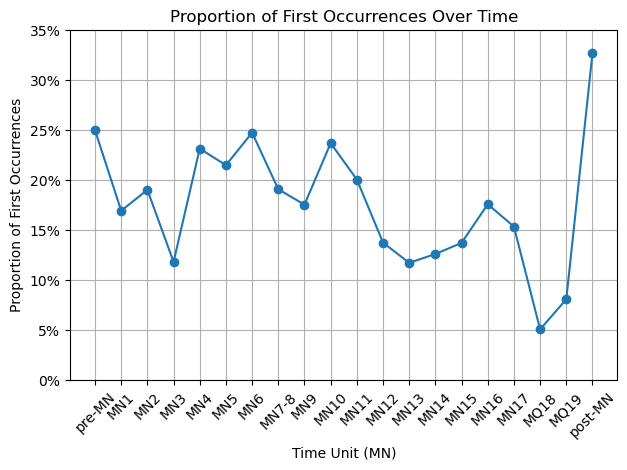

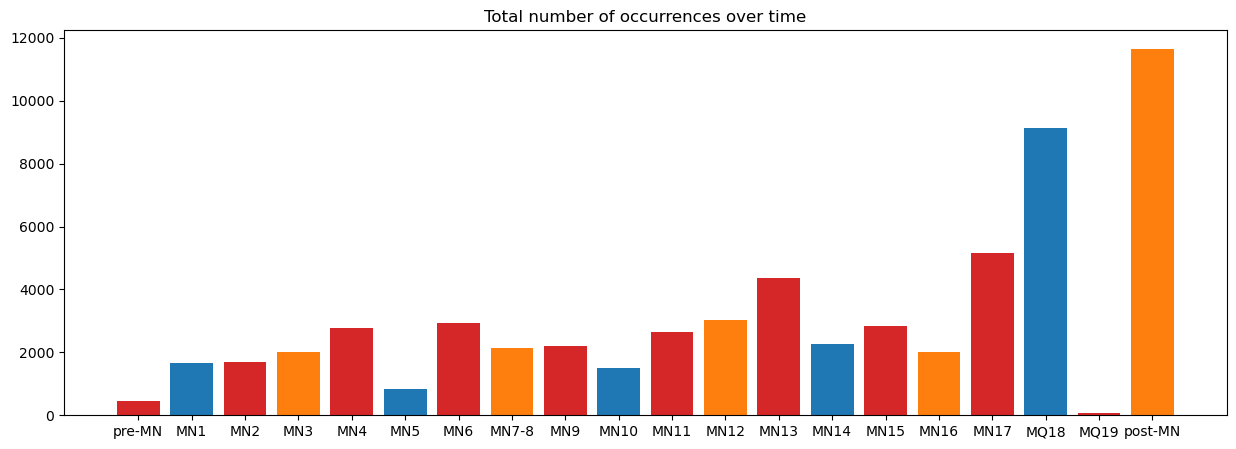

In [306]:
my_order = {
'pre-MN': 0,
'MN1': 1,
'MN2': 2,
'MN3': 3,
'MN4': 4,
'MN5': 5,
'MN6': 6,
'MN7-8': 7,
'MN9': 8,
'MN10': 9,
'MN11': 10,
'MN12': 11,
'MN13': 12,
'MN14': 13,
'MN15': 14,
'MN16': 15,
'MN17': 16,
'MQ18': 17,
'MQ19': 18,
'post-MN': 19
}

def create_df():

    data = clean_and_process()
    # group by species and mn for calculate number of each species in every mn
    grouped_data = data.groupby(["SPECIES_ID", "MN"]).size().reset_index(name="Count")
    # group by species sort each mn get the earliest mn and store in the df
    first_observed_df = grouped_data.groupby("SPECIES_ID")["MN"].apply(lambda x: sorted(x, key=lambda mn: my_order.get(mn))[0]).reset_index(name="First_Observed_MN")
    # count first occurrences in each mn(groupby mn and count)
    first_count = first_observed_df.groupby("First_Observed_MN")["SPECIES_ID"].count()
    # count total occurrences in each mn
    total_count = grouped_data.groupby("MN")["Count"].sum()
    # create the new df contains total and first count in each mn
    merged = pd.merge(first_count, total_count, how="outer", left_index=True, right_index=True)
    # fill all nan to be 0 (means no occurrences found)
    merged.fillna(0, inplace=True)
    # add column of proportion to df: FIRST(THE SPECIES_ID COLUMN) / TOTAL (THE Count column)
    merged["first_occurrence_proportion"] = merged["SPECIES_ID"] / merged["Count"]
    # rename columns
    merged = merged.rename(columns={"SPECIES_ID": "Count_first", "Count": "Count_total", "first_occurrence_proportion": "Proportion_First_Occurrence"})

    # plot
    # plt.figure(figsize=(10, 6))
    mn = [mn for mn in my_order.keys()]
    plt.plot(mn, merged['Proportion_First_Occurrence'], marker='o', linestyle='-')
    plt.xlabel('Time Unit (MN)')
    plt.ylabel('Proportion of First Occurrences')
    plt.title('Proportion of First Occurrences Over Time')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.gca().set_yticks(plt.gca().get_yticks())
    plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])
    plt.tight_layout()
    plt.show()

    # plot total number
    fig, ax = plt.subplots(figsize=(15, 5))
    bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']
    ax.bar(mn, merged['Count_total'], color = bar_colors)
    ax.set_title('Total number of occurrences over time')
    plt.show()

    return grouped_data, first_observed_df

if __name__ == '__main__':
    create_df()

### Idea of solution
The data is cleaned to remove incomplete or inaccurate entries and assign MN time units to each occurrence based on age information.
Corrections are made for specific localities based on expert input. <br/>
Two DataFrames are generated: one showing species occurrences per MN time unit and another indicating the first MN time unit each species appears.
Proportions of first occurrences to total occurrences are calculated and added to the first DataFrame.<br/>
Line and bar plots visualize the proportion of first occurrences and total occurrences over MN time units, respectively.<br/>
The analysis offers insights into species distribution and timing throughout the MN time units, aiding in understanding species appearance patterns.<br/>

## 5 Groprapgic pattern
a) Create a DataFrame that collects the following informa- tion for every locality: locality number (LIDNUM), longitude, latitude, time unit, number of first occurrences in the locality, number of all occur- rences in the locality and proportion of first occurrences in the locality. 5Note, you should use LIDNUM to identify unique localities and not the NAME variable (why?).<br/>
b) Visualize the distribution of localities in space and time. For each time unit, plot the LAT and LONG coordinates of each locality (corresponding to the time unit). For example, you can use the above codes to create a geographic map and then use a standard matplotlib scatter plot to add the localities. Choose the marker size for each locality such that it is relative to the number of occurrences in the locality (bigger markers for bigger localities).<br/>
c) Based on exercises 4 and 5, what kind of observations about sampling can you make? Are there differences in sampling density over space and time? Compare some basic sampling properties between Africa, Asia and Europe, e.g. spatial coverage and average number of occurrences per locality.<br/>

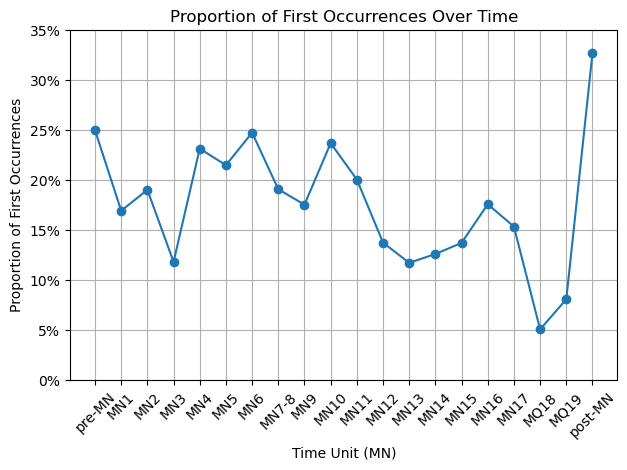

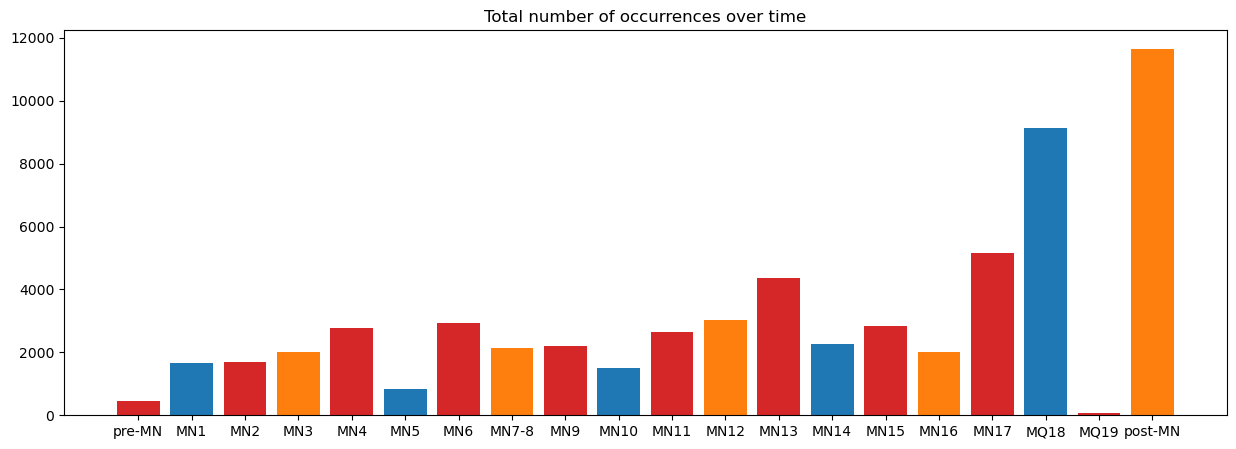

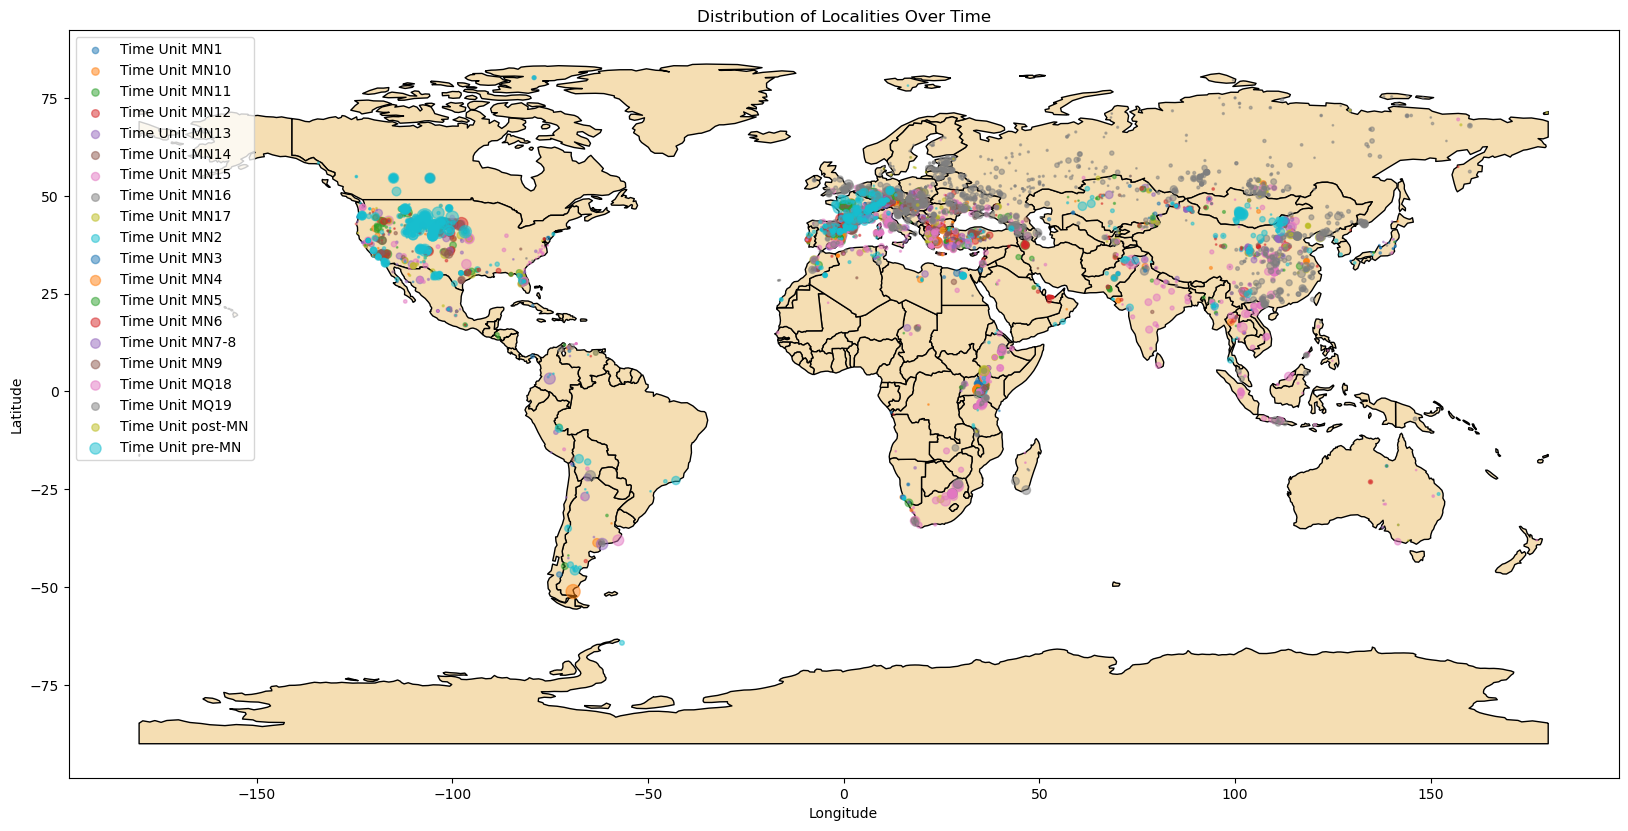

In [307]:
def get_locality(grouped_data, first_observed_df, data):
    # merge species data per mn with first mn
    merged_df = pd.merge(grouped_data, first_observed_df, on='SPECIES_ID')
    merged_df = merged_df.rename(columns={"Count": "Total_Count_Per_MN"})
    # get info(lat long lidnum mn and id) from original data
    new_df = data[['LIDNUM', 'LAT', 'LONG','MN', 'SPECIES_ID']]
    # merge info with species and mn details
    merged_df2 = pd.merge(merged_df, new_df, on=['SPECIES_ID', 'MN'])

    # get all first locality unique lidnum, nunque() calculate each lidnum's first occurrences(First_Observed_MN) times
    first_occurrences = merged_df2.groupby('LIDNUM')['First_Observed_MN'].nunique()
    # count total occurrences 
    all_occurrences = merged_df2.groupby('LIDNUM').size()
    proportion_first = first_occurrences / all_occurrences

    locality_df = pd.DataFrame({
        'LIDNUM': first_occurrences.index,       # Unique locality numbers
        'Longitude': merged_df2.groupby('LIDNUM')['LONG'].first(),      # Longitude of the locality
        'Latitude': merged_df2.groupby('LIDNUM')['LAT'].first(),        # Latitude of the locality
        'Time_Unit': merged_df2.groupby('LIDNUM')['MN'].first(),        # Uncomment if necessary
        'First_Occurrences': first_occurrences,
        'All_Occurrences': all_occurrences,
        'Proportion_First': proportion_first
    })
    return locality_df

if __name__ == '__main__':
    grouped_data, first_observed_df = create_df()
    data = clean_and_process()
    df = get_locality(grouped_data, first_observed_df, data)
    # print(df.iloc[400])
    # Plot world map
    # Convert DataFrame to GeoDataFrame
    geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
    gdf = geopandas.GeoDataFrame(df, geometry=geometry)

    # Plot base map
    world = geopandas.read_file("110m_cultural/ne_110m_admin_0_countries.shp")
    ax = world.plot(figsize=(20, 10), color='wheat', edgecolor='black')

    # Loop through each time unit and plot localities
    for time_unit, group in gdf.groupby('Time_Unit'):
        # Calculate marker size relative to the number of occurrences
        marker_size = group['All_Occurrences']
        
        # Plot localities for the current time unit
        group.plot(ax=ax, markersize=marker_size, label=f'Time Unit {time_unit}', alpha=0.5)

    # Set plot title and labels
    plt.title('Distribution of Localities Over Time')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    # Show legend
    plt.legend()
    # Show plot
    plt.show()
   

### Idea of solution
1. The get_locality function merges the species data per MN with the first MN observed for each species. It then extracts relevant information such as LIDNUM, latitude, longitude, time unit, and species ID from the original data. The number of first occurrences and total occurrences for each locality are calculated, along with the proportion of first occurrences. These details are aggregated into a DataFrame.
<br/>
2. The function visualizes the distribution of localities in space and time. It converts the DataFrame into a GeoDataFrame, plots a base map, and then loops through each time unit to plot localities. The marker size is determined relative to the number of occurrences in each locality, with larger markers representing higher occurrence counts.
<br/>
3. Observations about sampling density over space and time can be made by examining the distribution of localities on the map. Differences in sampling density between regions and time units can be identified visually. Additionally, comparing basic sampling properties such as spatial coverage and average number of occurrences per locality between different continents like Africa, Asia, and Europe can provide insights into the sampling efforts and potential biases in the data collection process.

### Discussion
1. <strong>Why use LIDNUM to identify unique localities and not the NAME variable？</strong><br/>
-- LIDNUM is a numerical identifier, which typically makes it more robust for indexing and identifying unique records compared to textual names. It can easily handle cases where localities have similar names but different numerical identifiers.<br/>
<br/>
2. <strong>Based on exercises 4 and 5, what kind of observations about sampling can you make? Are there differences in sampling density over space and time? Compare some basic sampling properties between Africa, Asia and Europe, e.g. spatial coverage and average number of occurrences per locality.</strong><br/>
\
a.Spatial Coverage: The spatial coverage of sampled localities is extensive, with the highest concentration observed in Europe, followed by Asia. In addition, there is notable sampling in the mid-western United States, along the east and west edges of South America, and the eastern regions of Africa. However, there is limited sampling coverage in Australia, indicating a smaller distribution of sampled localities in that region.<br/>
<br/>
b.Sampling Density Over Space: Although Europe, the United States, and Asia exhibit significant sampling efforts, Europe stands out with the highest level of sampling density, covering almost the entire continent. In the United States, high sampling density is concentrated in the central and near-western regions. Conversely, sampling across Asia appears to be more dispersed and does not demonstrate high density in any specific area.<br/>
<br/>
c.Temporal Coverage: In Europe, extensive sampling efforts are observed during the pre-MN and MQ19 time units, with additional density centered on the southeast part of the continent during other time units. Similarly, in the United States, high levels of sampling are evident during the pre-MN period, followed by significant efforts during MN9 and MN12. Meanwhile, in Asia, the MQ19 time unit shows the most extensive sampling, with notable efforts also observed during MN15 and MQ19.

## 6 Sampling
For each locality, look at a ten by ten degrees area (in latitude and longitude) centered around the locality. Record the total number of occurrences and total number of first occurrences found within that square in the time unit corresponding to the focal locality. Also, record the total number of occurrences within that square in the preceding time unit (relative to the focal locality). Record these numbers into the DataFrame that was created in exercise 5 (add new columns).

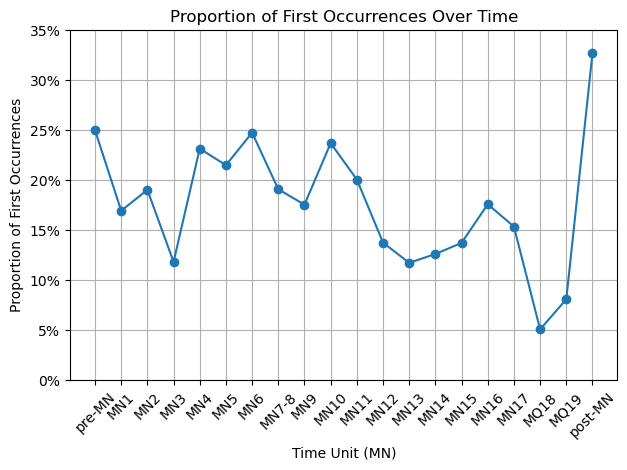

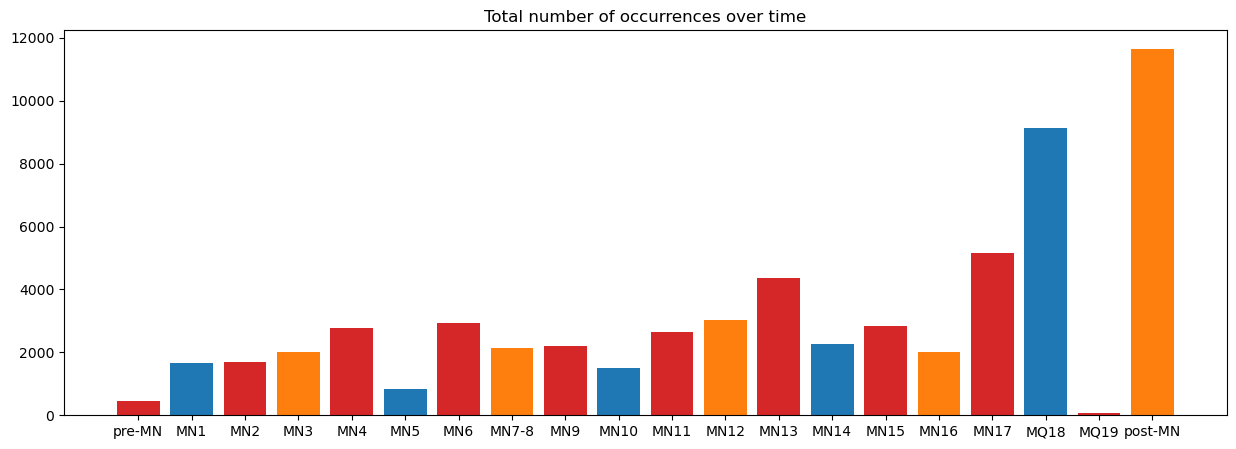

In [308]:
def add_focal_area(locality_df):
    locality_df[['Latitude', 'Longitude']] = locality_df[['Latitude', 'Longitude']].apply(pd.to_numeric, errors='coerce')
    lon_range = 10
    lat_range = 10

    locality_df['Total_Occurrences_Area'] = 0
    locality_df['Total_First_Occurrences_Area'] = 0
    locality_df['Total_Occurrences_Previous'] = 0

    # get 10x10 area range
    for index, row in locality_df.iterrows():
        lon = row['Longitude']
        lat = row['Latitude']
        time_unit = row['Time_Unit']
        time_unit_index = my_order[time_unit]
        lon_min = lon - lon_range / 2
        lon_max = lon + lon_range / 2
        lat_min = lat - lat_range / 2
        lat_max = lat + lat_range / 2
        # filter focal area data from df
        filtered_df = locality_df[
            (locality_df['Longitude'] >= lon_min) &
            (locality_df['Longitude'] <= lon_max) &
            (locality_df['Latitude'] >= lat_min) &
            (locality_df['Latitude'] <= lat_max)
        ]

        total_occurrences_area = filtered_df['All_Occurrences'].sum()
        first_occurrences_area = filtered_df['First_Occurrences'].sum()

        total_occurrences_preceding = locality_df[
            (locality_df['Longitude'] >= lon_min) &
            (locality_df['Longitude'] <= lon_max) &
            (locality_df['Latitude'] >= lat_min) &
            (locality_df['Latitude'] <= lat_max) &
            (locality_df['Time_Unit'] == 'MN{}'.format(time_unit_index - 1)) #MN{?} - 1
        ]['All_Occurrences'].sum()

        locality_df.at[index, 'Total_Occurrences_Area'] = total_occurrences_area
        locality_df.at[index, 'Total_First_Occurrences_Area'] = first_occurrences_area
        locality_df.at[index, 'Total_Occurrences_Previous'] = total_occurrences_preceding
    # print(locality_df.iloc[800])
    return locality_df
if __name__ == '__main__':
    grouped_data, first_observed_df = create_df()
    data = clean_and_process()
    locality_df = get_locality(grouped_data, first_observed_df, data)
    add_focal_area(locality_df)

### Idea of solution
1. The add_focal_area function first converts the latitude and longitude columns in the DataFrame to numeric types. It then initializes three new columns in the DataFrame to record the total number of occurrences and first occurrences within a 10x10 degrees area centered around each locality, as well as the total number of occurrences in the preceding time unit within the same area.

2. Next, for each locality, it iterates through the DataFrame to calculate the latitude and longitude ranges for the 10x10 degrees area. It filters the DataFrame to select only the data within this area. It computes the total number of occurrences and first occurrences within the area and the total number of occurrences in the preceding time unit within the same area.

## 7 Logistic regression
1.  Create the regression data set. Only use localities within the co-ordinates -25<LONG<40 and LAT>35 and time unit within MN2- MQ19 (why not include MN1?). Create an m × 2 array, where m is the total number of occurrences in all the localities. Each row in the array represents one occurrence. For each occurrence, fill in to the first column of the array the number of occurrences in the focal area in the previous time unit (calculated in exercise 6). For the second column, fill in 1 for a first occurrence and 0 for other occurrences.
2. perform logistic regression
3. Plot regression curve and 95%-confidence intervals

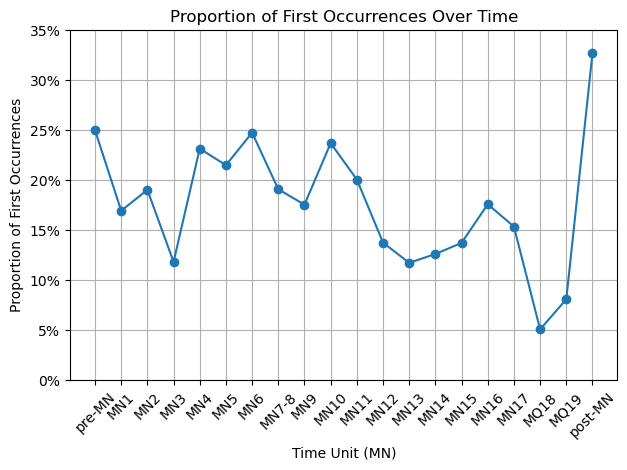

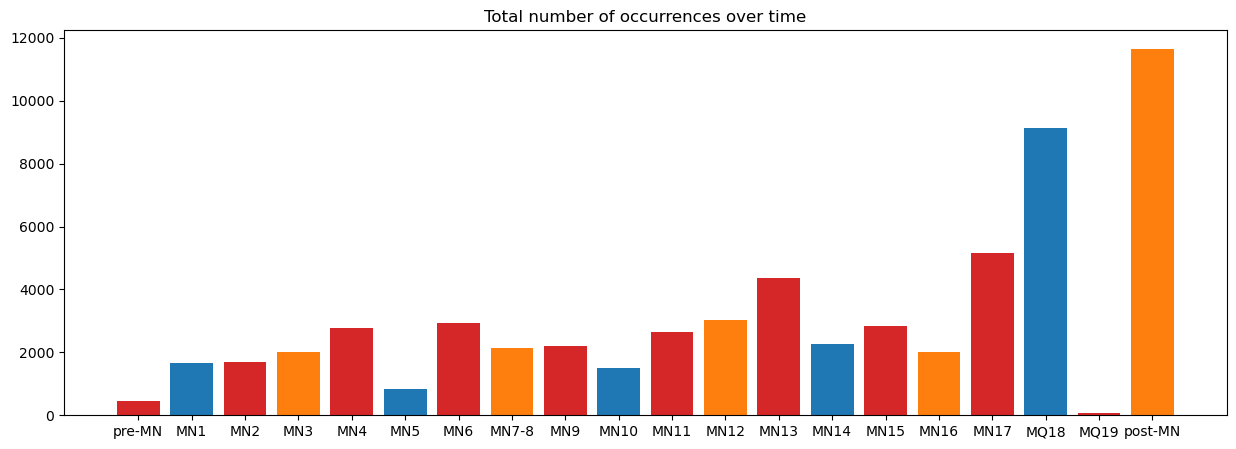

Optimization terminated successfully.
         Current function value: 0.539825
         Iterations 5


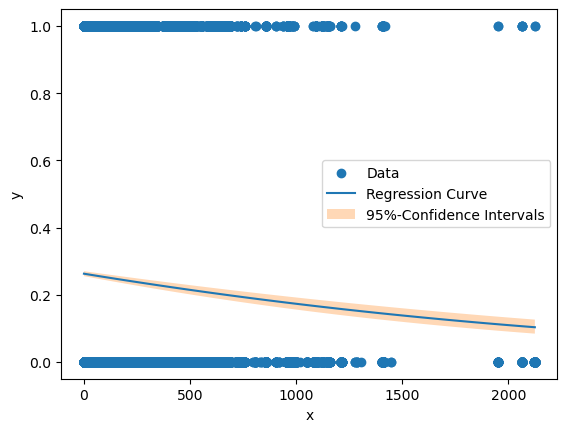

In [309]:
def create_arr(locality_df):
    
    occurrences_previous = locality_df[['LIDNUM', 'Total_Occurrences_Previous']].set_index('LIDNUM')
    
    # Filter data
    data['LONG'] = pd.to_numeric(data['LONG'], errors='coerce')
    data['LAT'] = pd.to_numeric(data['LAT'], errors='coerce')
    filtered_data = data[
    (data['LONG'] > -25) &
    (data['LONG'] < 40) &
    (data['LAT'] > 35) &
    (data['MN'].isin(['MN2', 'MN3', 'MN4', 'MN5', 'MN6', 'MN7-8', 'MN9', 'MN10', 'MN11', 'MN12', 'MN13', 'MN14', 'MN15', 'MN16', 'MN17', 'MQ18', 'MQ19']))]

    # # why not mn1
    # MN1_data = data[
    # (data['LONG'] > -25) &
    # (data['LONG'] < 40) &
    # (data['LAT'] > 35) &
    # (data['MN'].isin(['MN1']))]

    # with_MN1 = data[
    # (data['LONG'] > -25) &
    # (data['LONG'] < 40) &
    # (data['LAT'] > 35) &
    # (data['MN'].isin(['MN1', 'MN2', 'MN3', 'MN4', 'MN5', 'MN6', 'MN7-8', 'MN9', 'MN10', 'MN11', 'MN12', 'MN13', 'MN14', 'MN15', 'MN16', 'MN17', 'MQ18', 'MQ19']))]

    # print(MN1_data.shape[0]/with_MN1.shape[0])


    filtered_data = filtered_data[['LIDNUM', 'SPECIES_ID', 'MN']].set_index('SPECIES_ID')

    first_df = first_observed_df.set_index('SPECIES_ID')

    merge_first = filtered_data.join(first_df, how='left', rsuffix='oldest').reset_index().set_index('LIDNUM')

    merge_previous = merge_first.join(occurrences_previous, how='left', rsuffix='preceding').reset_index()
    merge_previous['is_first'] = (merge_previous['MN'] == merge_previous['First_Observed_MN']).astype('int')

    regression_df = merge_previous[['Total_Occurrences_Previous', 'is_first']].copy()
    array = np.array(regression_df)
    X = array[:,0]
    X = sm.add_constant(X)
    y = array[:,1]

    model = sm.Logit(y, X)
    result = model.fit()
    coefficients = result.params
    confidence95 = result.conf_int(alpha=0.05)


    x_values = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
    y_values = logit_curve(x_values, coefficients)

    #confidence intervals
    upper_ci = logit_curve(x_values, confidence95[:,0])
    lower_ci = logit_curve(x_values, confidence95[:,1])


    plt.scatter(X[:, 1], y, label='Data')
    plt.plot(x_values, y_values, label='Regression Curve')
    plt.fill_between(x_values, lower_ci, upper_ci, alpha=0.3, label='95%-Confidence Intervals')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

    return result

def logit_curve(x, coefficients):
        return 1 / (1 + np.exp(-coefficients[0] - coefficients[1] * x))

if __name__ == '__main__':
    grouped_data, first_observed_df = create_df()
    data = clean_and_process()
    df = get_locality(grouped_data, first_observed_df, data)
    locality_df = add_focal_area(df)
    create_arr(locality_df)


### Idea of solution
1.The create_arr function first extracts the total number of occurrences in the focal area in the previous time unit for each locality and whether each occurrence is a first occurrence or not. Then, it constructs a logistic regression model using these variables to predict whether an occurrence is a first occurrence or not.

2.The function filters the data based on the specified conditions for longitude, latitude, and time unit, excluding MN1. It then joins this filtered data with the total occurrences in the previous time unit for each locality and whether each occurrence is a first occurrence. The logistic regression model is fitted using the total occurrences in the previous time unit as the predictor variable and whether each occurrence is a first occurrence as the response variable.

3.After fitting the model, it calculates the logistic regression coefficients and 95% confidence intervals. It then generates the logistic regression curve and plots it along with the data points and the 95% confidence intervals. Finally, the function returns the logistic regression model.

### Discussion
1. <strong>Why not include MN1?</strong><br/>
Depending on the map, it doesn't show an obvious MN1 sampled distribution of localities on the European continent, and the percentage of MN1 in all time units in Europe area is 0.014, which indicates a small proportion. This suggests that MN1 data may be limited or less relevant to the research questions. Excluding MN1 may improve the coherence and interpretability of the analysis.


## 8 Proportion for each locality in the focal area using regression

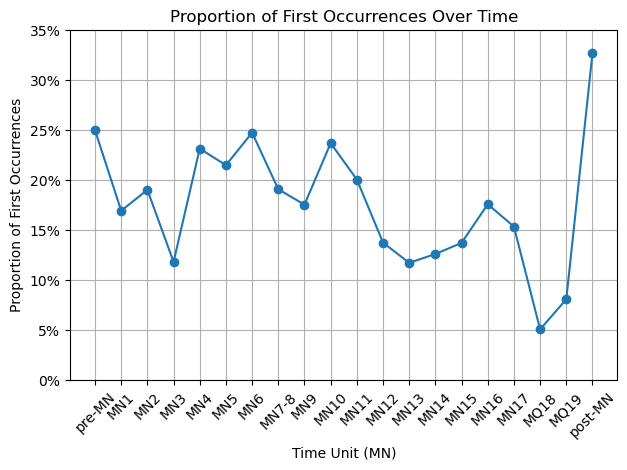

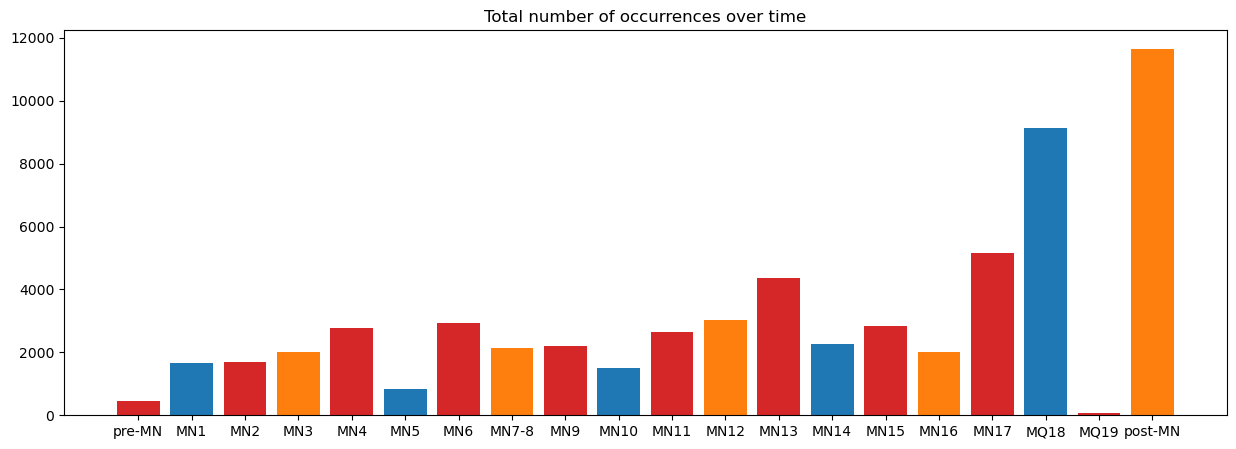

Optimization terminated successfully.
         Current function value: 0.539825
         Iterations 5


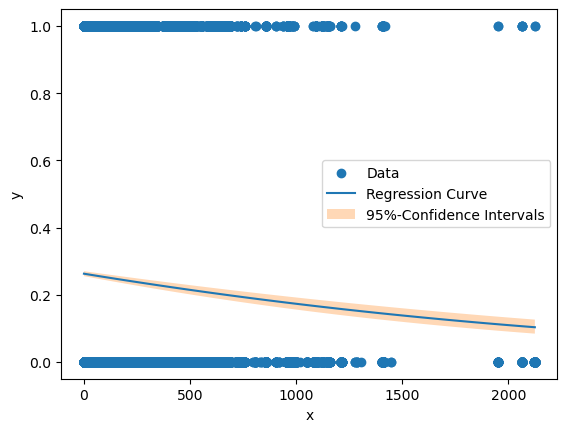

In [310]:
def calculate_expected_proportion(locality_df, result):
    # use the logistic regression function before
    coefficients = result.params
    locality_df['first_probability'] = logit_curve(locality_df['Total_Occurrences_Previous'], coefficients)
    return locality_df
    # print(locality_df.columns)

if __name__ == '__main__':
    grouped_data, first_observed_df = create_df()
    data = clean_and_process()
    df = get_locality(grouped_data, first_observed_df, data)
    locality_df = add_focal_area(df)
    result = create_arr(locality_df)
    calculate_expected_proportion(locality_df, result)

## 9 Probability of first occurrence more than the prediction

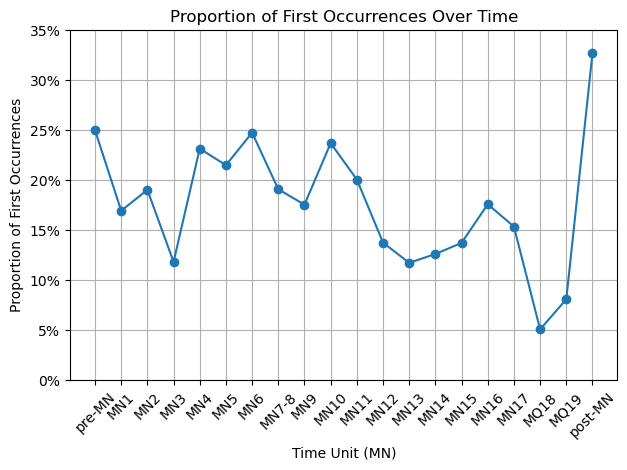

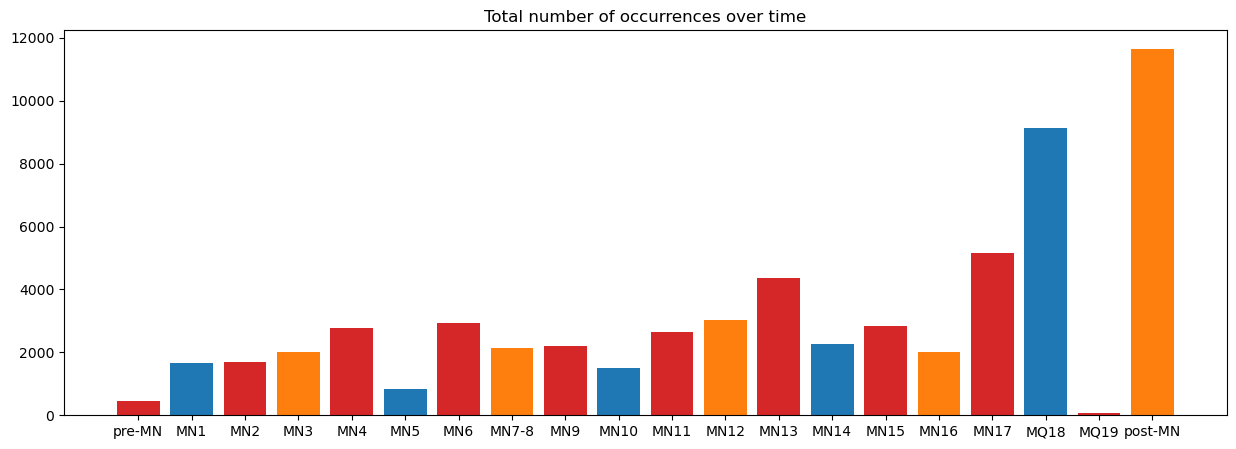

Optimization terminated successfully.
         Current function value: 0.539825
         Iterations 5


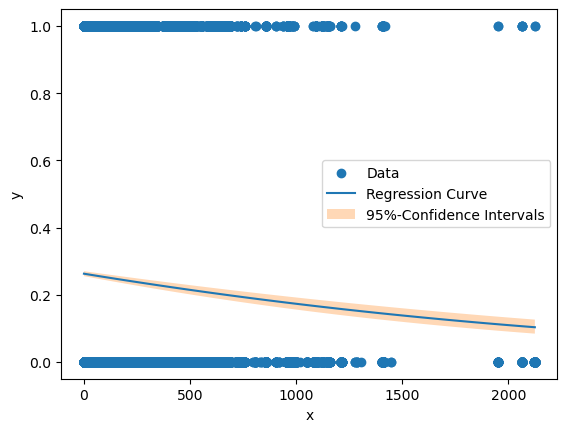

In [311]:
def more_first(locality_df):
    n = locality_df['All_Occurrences']
    k = locality_df['First_Occurrences']
    p = locality_df['first_probability']

    locality_df['binom_probability'] = 1 - binom.cdf(k, n, p)
    # probability
    more_than_expected = locality_df[locality_df['binom_probability'] <= 0.05]
    # print("locality_df")
    # print(locality_df)
    return locality_df


if __name__ == '__main__':
    grouped_data, first_observed_df = create_df()
    data = clean_and_process()
    df = get_locality(grouped_data, first_observed_df, data)
    df2 = add_focal_area(df)
    result = create_arr(df2)
    locality_df = calculate_expected_proportion(df2, result)
    more_first(locality_df)
    

### Idea of solution:
For each locality in the DataFrame locality_df, the function extracts the total number of occurrences (n), the number of first occurrences (k), and the expected probability of a given occurrence to be a first occurrence (p). Then, it computes the binomial probability of observing as many or more first occurrences using the formula 1 - binom.cdf(k, n, p). This represents the probability of observing k or more successes (first occurrences) out of n trials (total occurrences) with a success probability of p.

# 10 Describe overall patterns
1. Plot locality on map and indicate significance level with sliding color scheme
2. Highlight p_level that less than 0.05
3. describe overall level

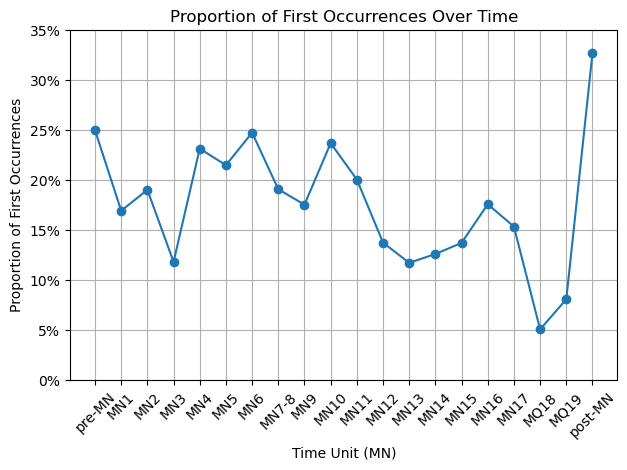

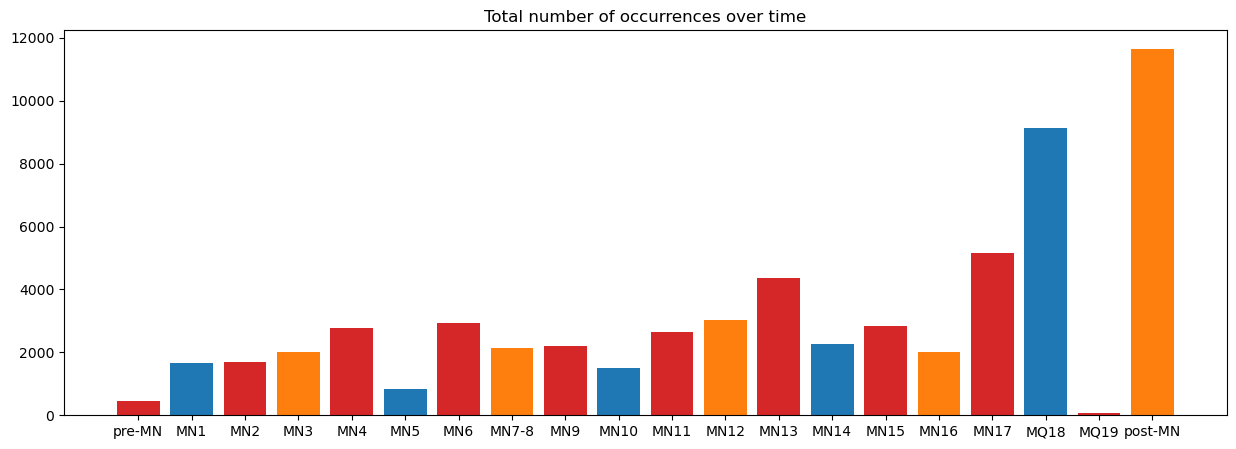

Optimization terminated successfully.
         Current function value: 0.539825
         Iterations 5


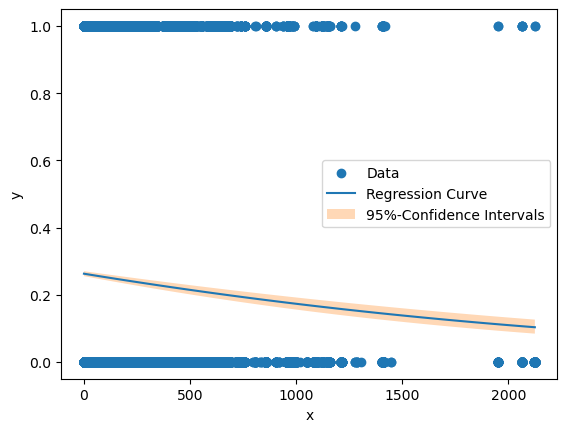

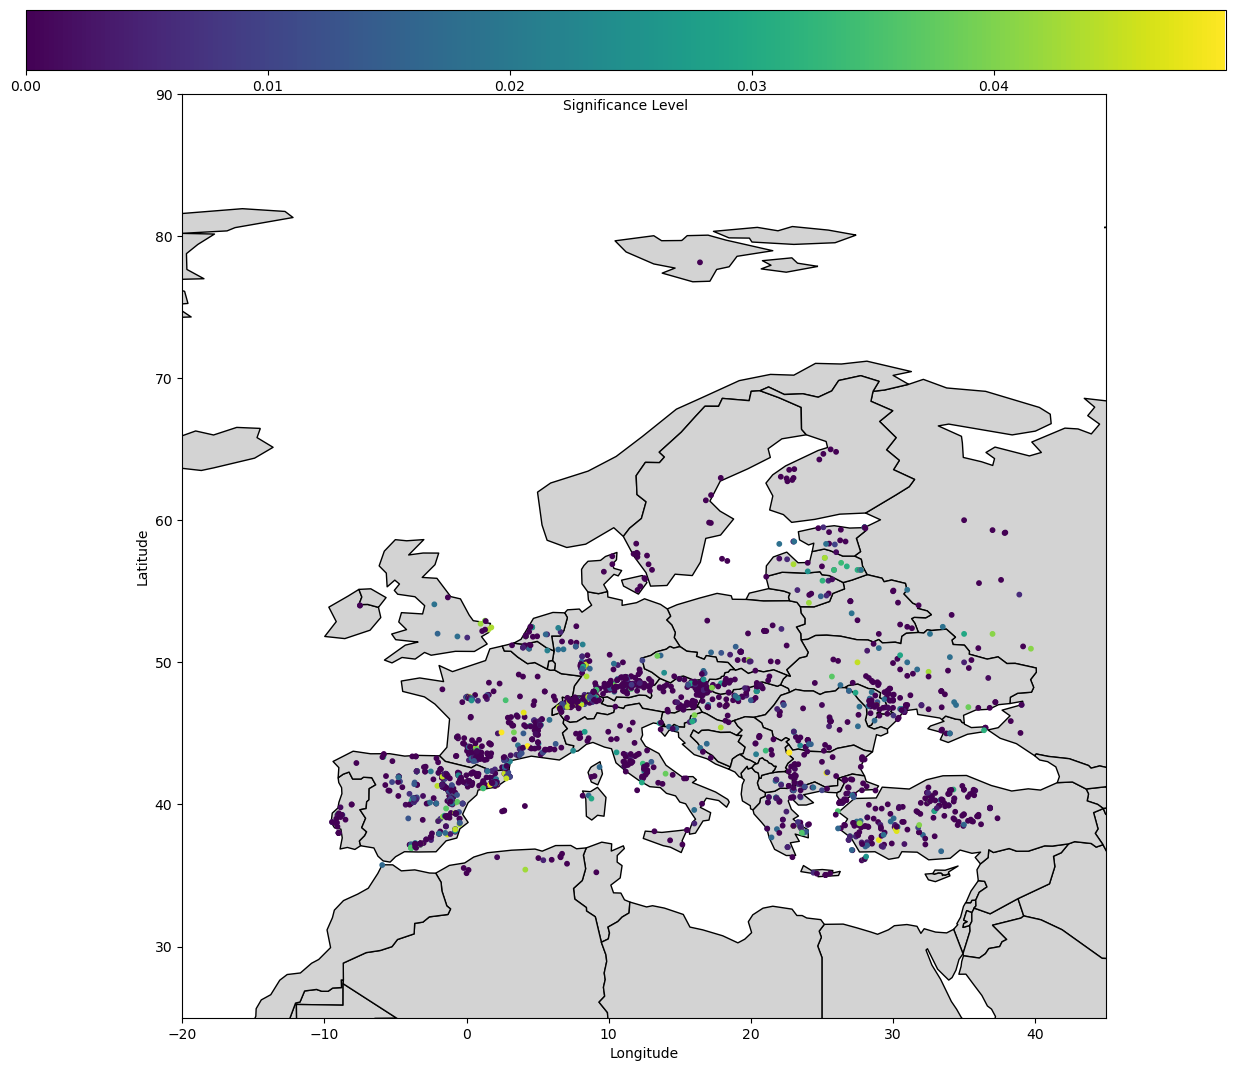

In [312]:
def plot_localities_on_map(locality_df):
    # Filter localities based on coordinates and significance level
    # print("get the df")
    # print(locality_df)
    locality_df[['Latitude', 'Longitude']] = locality_df[['Latitude', 'Longitude']].apply(pd.to_numeric, errors='coerce')

    # Convert Longitude and Latitude to GeoDataFrame geometry
    geometry = geopandas.points_from_xy(locality_df['Longitude'], locality_df['Latitude'])
    gdf = geopandas.GeoDataFrame(locality_df, geometry=geometry)

    # Filter localities based on coordinates and significance level
    filtered_localities = gdf[(gdf['Longitude'] > -25) & (gdf['Longitude'] < 40) & (gdf['Latitude'] > 35)]
    significant_localities = filtered_localities[filtered_localities['binom_probability'] < 0.05]

    # Define Europe bounding box
    europe_bbox = (-20, 25, 45, 90) 

    # Create plot
    fig, ax = plt.subplots(figsize=(15, 12))
    ax.set_xlim(europe_bbox[0], europe_bbox[2])
    ax.set_ylim(europe_bbox[1], europe_bbox[3])

    # Plot Europe map
    # europe = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    europe = geopandas.read_file("110m_cultural/ne_110m_admin_0_countries.shp")
    europe.plot(ax=ax, color='lightgray', edgecolor='black')

    # Create ScalarMappable for colorbar
    norm = Normalize(vmin=significant_localities['binom_probability'].min(), vmax=significant_localities['binom_probability'].max())
    sm = ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])

    # Plot significant localities with color representing significance level
    significant_localities.plot(ax=ax, marker='o', color=sm.to_rgba(significant_localities['binom_probability']), markersize=10)

    # Add colorbar
    cax = fig.add_axes([0.1, 0.9, 0.8, 0.05])  # [left, bottom, width, height]
    cbar = plt.colorbar(sm, cax=cax, orientation='horizontal', label='Significance Level')

    # Set labels within the plot area
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Show plot
    plt.show()

if __name__ == '__main__':
    # Load the filtered data and perform logistic regression
    grouped_data, first_observed_df = create_df()
    data = clean_and_process()
    df = get_locality(grouped_data, first_observed_df, data)
    df2 = add_focal_area(df)
    result = create_arr(df2)
    df3 = calculate_expected_proportion(df2, result)
    locality_df = more_first(df3)
    plot_localities_on_map(locality_df)

### Discussion
1. <strong>Describe briefly the overall patterns that you observe.</strong><br/>
The values observed on the map indicate a significant range of the European continent where the significance level is less than 0.05. This suggests that the number of first-time occurrences in these areas is higher than expected, potentially rejecting the null hypothesis. Specifically, regions in the near-Mediterranean part of Europe exhibit observed numbers equal to or higher than the expected values, indicating areas with a notable abundance of first occurrences and significant patterns of occurrence.